# Ideal Parameter Analysis ($\delta=1$, $\tau=1.25$, $\alpha=1.75$) ($\delta$ lower bound, $\alpha$ lower bound)

In [1]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import sys

from datetime import datetime

sys.path.append('../../feeg_fmri_sync')

from feeg_fmri_sync.plotting import (
    plot_all_search_results_2d,
    plot_local_minima
)
from feeg_fmri_sync.search import (
    build_models,
    search_voxels
)
from feeg_fmri_sync.simulations import (
    build_model_to_fmri,
    generate_downsampled_simulated_fmri,
)
from feeg_fmri_sync.utils import (
    generate_descriptions_from_search_df,
)
from feeg_fmri_sync.vectorized_models import VectorizedHemodynamicModel

In [2]:
try_to_reuse = True
submit_to_cluster = False

## Initialize constants for Hemodynamic Modeling

In [3]:
### Initialize constants ###
sample_freq = 20
tr = 800
n_trs_skipped_at_beginning = 0
hemodynamic_response_window = 30

# Actual Values to generate data from
expected_delta = 1
expected_tau=1.25
expected_alpha=1.75

## Initialize constants for simulation

In [4]:
# Plot the generated data
# NOTE: only the first of the trials will be plotted
plot_generated_data = True

# Plot perfect data when modeling
plot_perfect_comparison = True

# noises to examine and plot when modeling
noise_range = range(1, 11)  
noises_to_plot = [3, 5, 10]

# trials we run for each condition and how many trials to plot when modeling
num_trials = 100  
num_trials_to_plot = 1

# models to examine
models_to_test = [
    {
        'name': 'downsample',
        'model': VectorizedHemodynamicModel,
        'fmri_data_generator': generate_downsampled_simulated_fmri,
    }
]

# eeg data types to use
eeg_data_options_for_fmri_generation = ['without_nans']
eeg_data_options_for_simulation = ['without_nans', 'with_nans']

## Display Generated Noise against Simulated Ground Truth

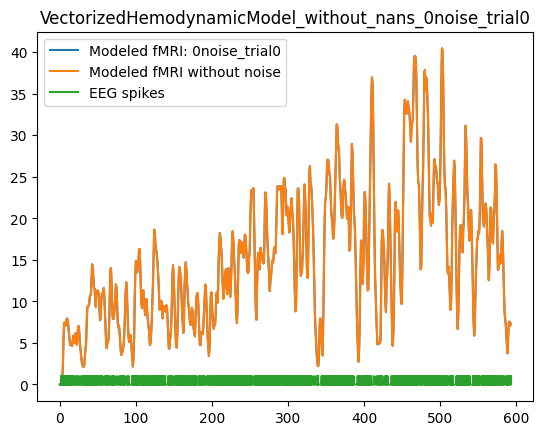

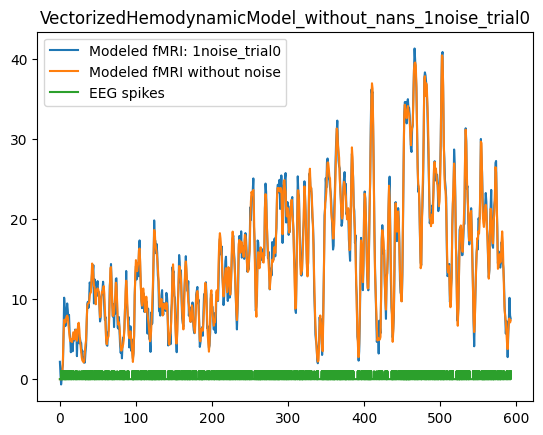

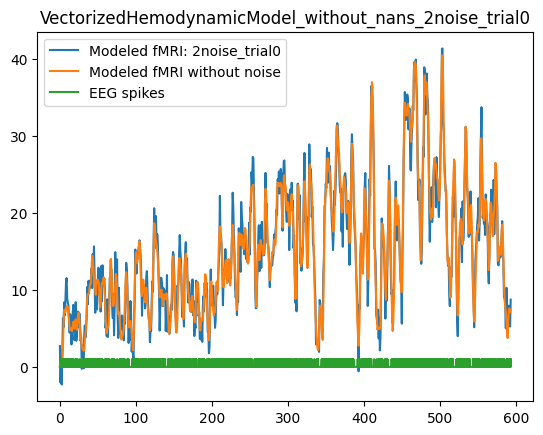

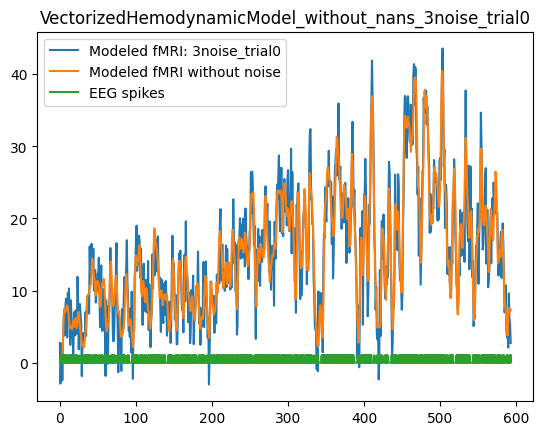

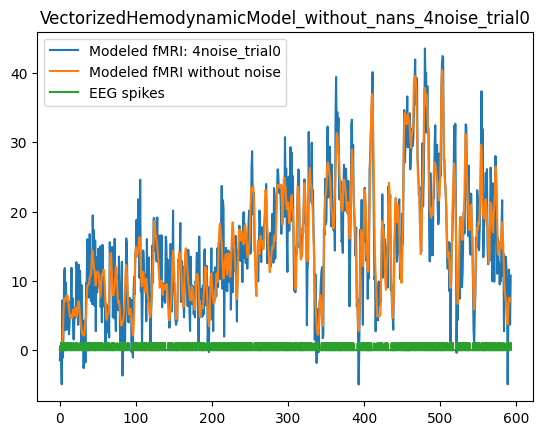

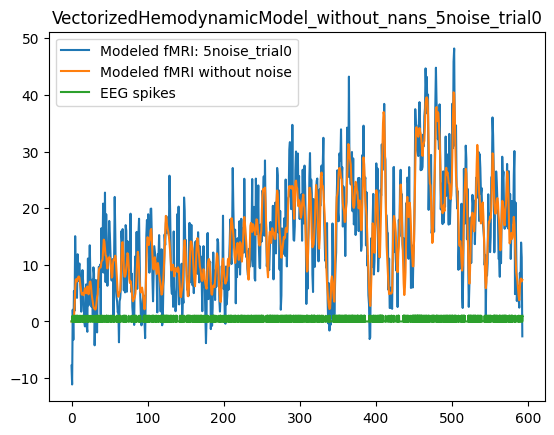

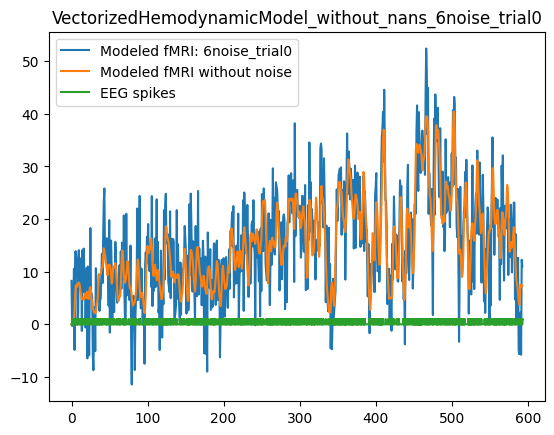

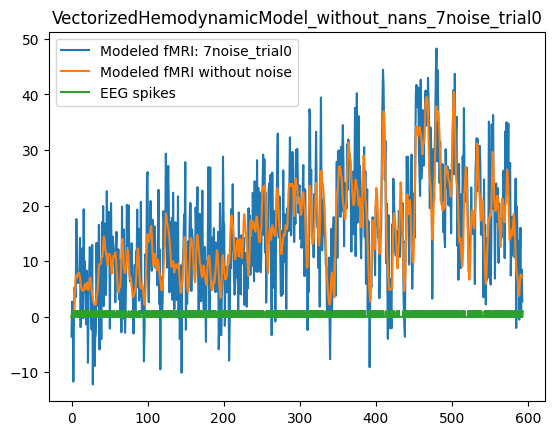

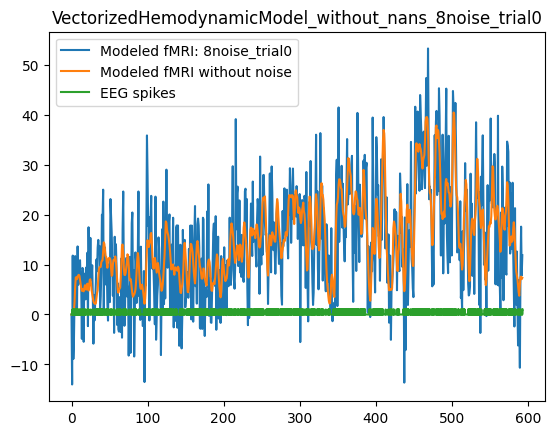

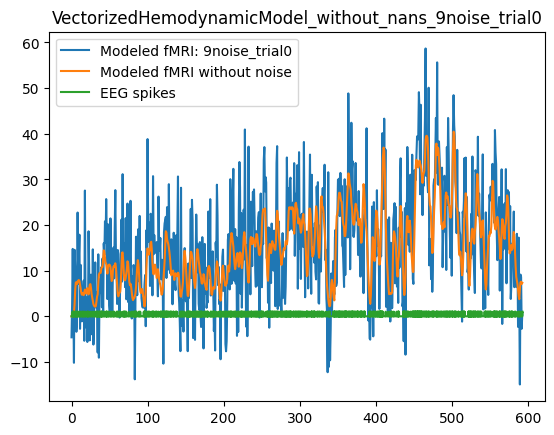

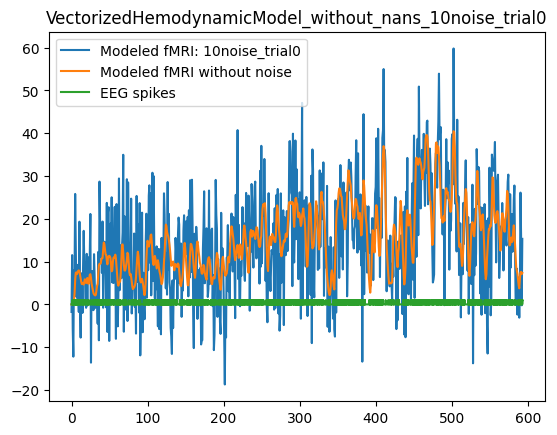

In [5]:
# Generate fMRI data
model_to_fmri = build_model_to_fmri(
    models_to_test,
    eeg_data_options_for_fmri_generation,
    expected_delta,
    expected_tau,
    expected_alpha,
    num_trials,
    num_trials_to_plot,
    noise_range,
    noises_to_plot,
    plot_perfect_comparison,
    tr,
    sample_freq,
    hemodynamic_response_window,
    plot_generated_data
)


## Initialize Analysis variables

In [6]:
step_size = 0.05

filename_substring = f'effect_of_ideal_params_delta{expected_delta}_tau{expected_tau}_alpha{expected_alpha}'
filename_ext = '.csv'
plot = True

delta = np.arange(1, 3+step_size, step_size)
tau = np.arange(0.75, 1.75+step_size, step_size)
alpha = np.arange(1.75, 2.25+step_size, step_size)

print(f'Delta target: {expected_delta}, Range:\n{delta}\n')
print(f'Tau target: {expected_tau}, Range:\n{tau}\n')
print(f'Alpha target: {expected_alpha}, Range:\n{alpha}\n')

Delta target: 1, Range:
[1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35 1.4  1.45 1.5  1.55 1.6  1.65
 1.7  1.75 1.8  1.85 1.9  1.95 2.   2.05 2.1  2.15 2.2  2.25 2.3  2.35
 2.4  2.45 2.5  2.55 2.6  2.65 2.7  2.75 2.8  2.85 2.9  2.95 3.  ]

Tau target: 1.25, Range:
[0.75 0.8  0.85 0.9  0.95 1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35 1.4
 1.45 1.5  1.55 1.6  1.65 1.7  1.75]

Alpha target: 1.75, Range:
[1.75 1.8  1.85 1.9  1.95 2.   2.05 2.1  2.15 2.2  2.25]



## Est vs Actual for all models at correct points

Scoring downsample_without_nans_without_nans delta=1, tau=1.25, alpha=1.75


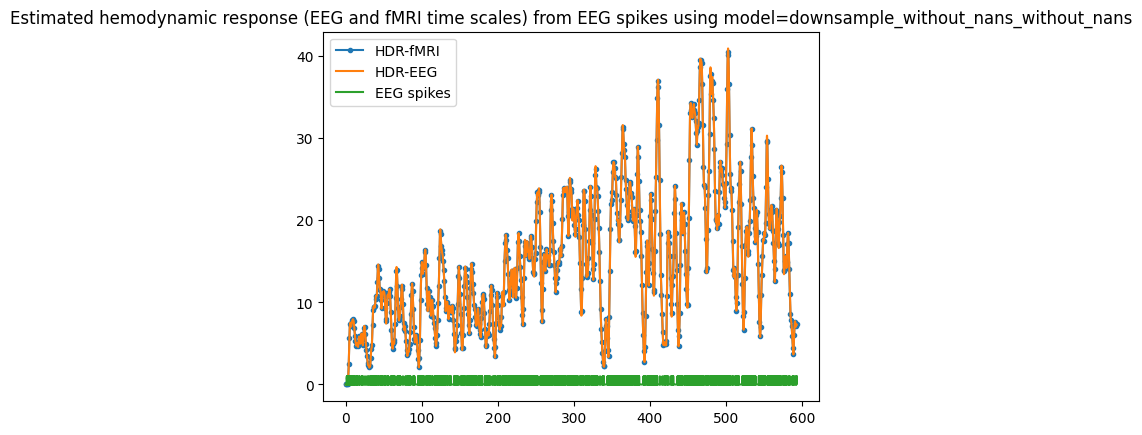

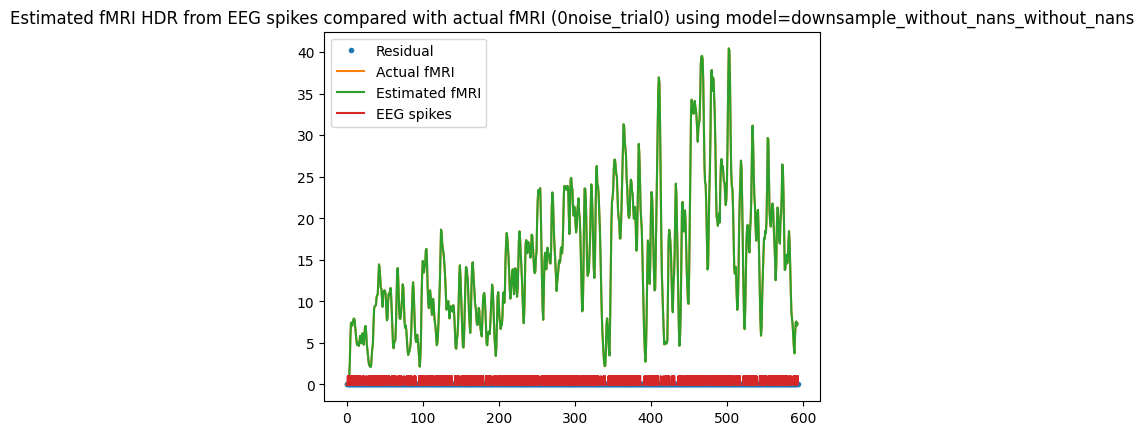

Residual Variance is 0.000000


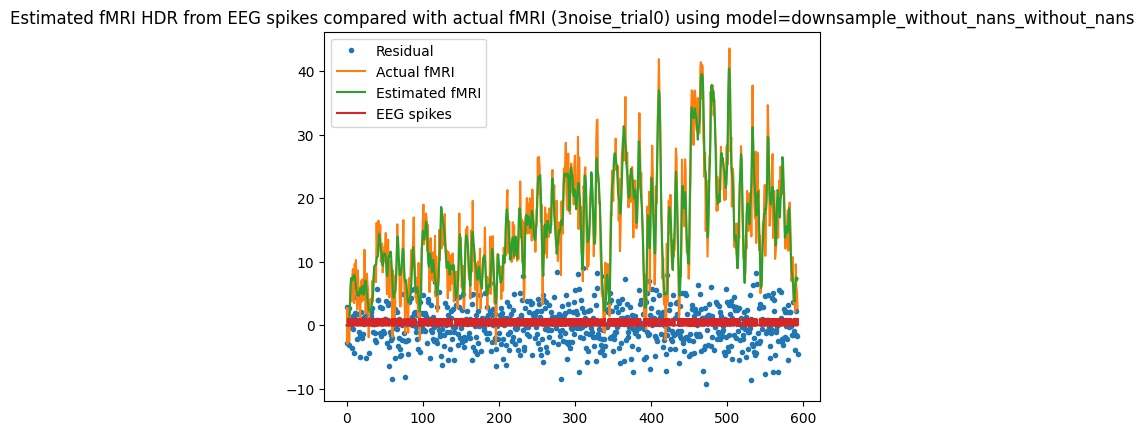

Residual Variance is 9.480105


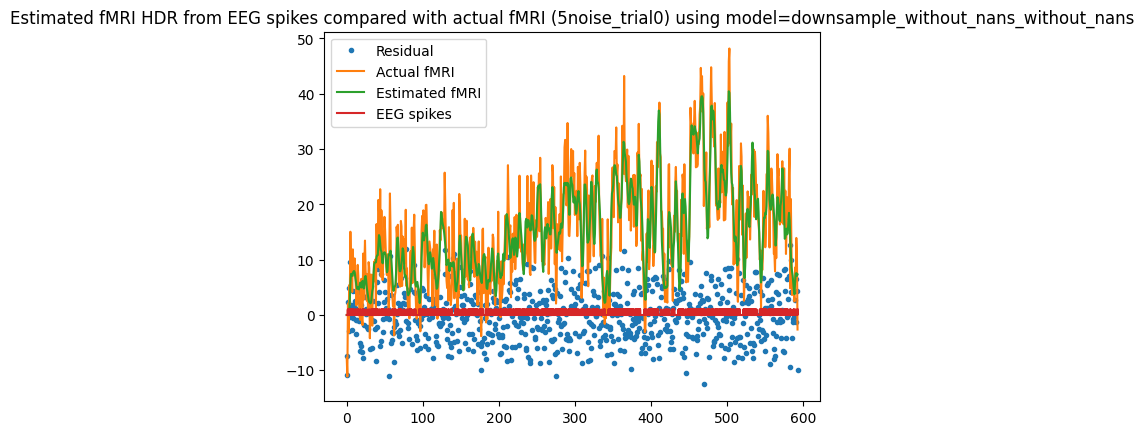

Residual Variance is 22.139766


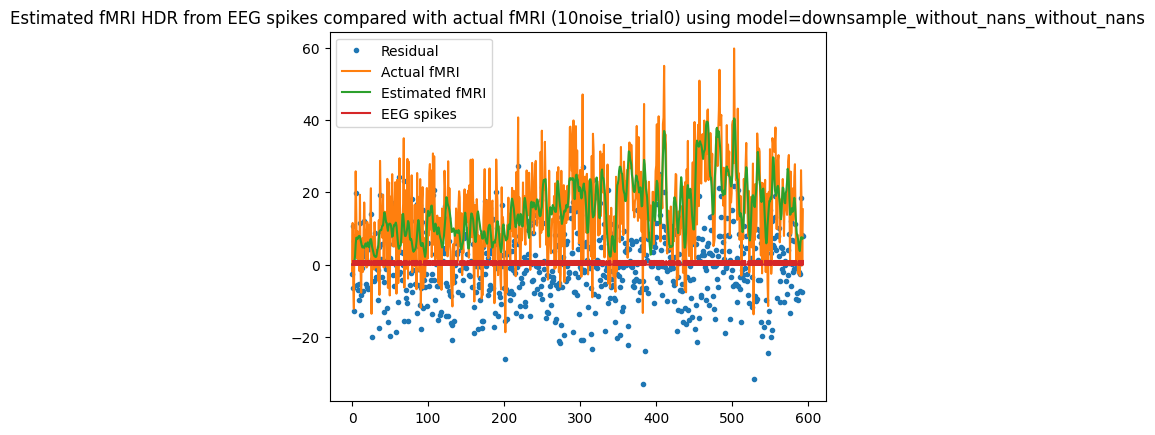

Residual Variance is 98.875778


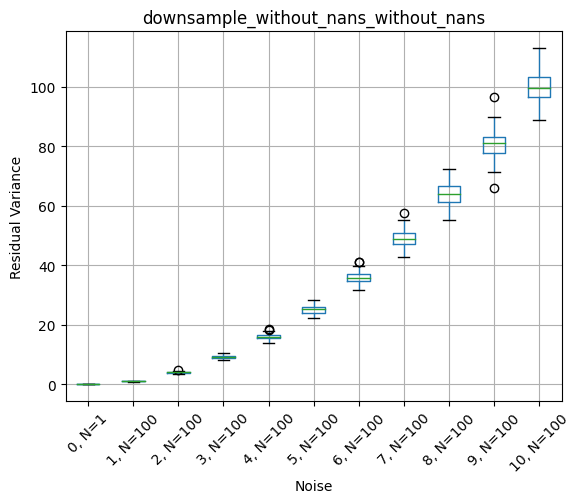

Scoring downsample_without_nans_with_nans delta=1, tau=1.25, alpha=1.75


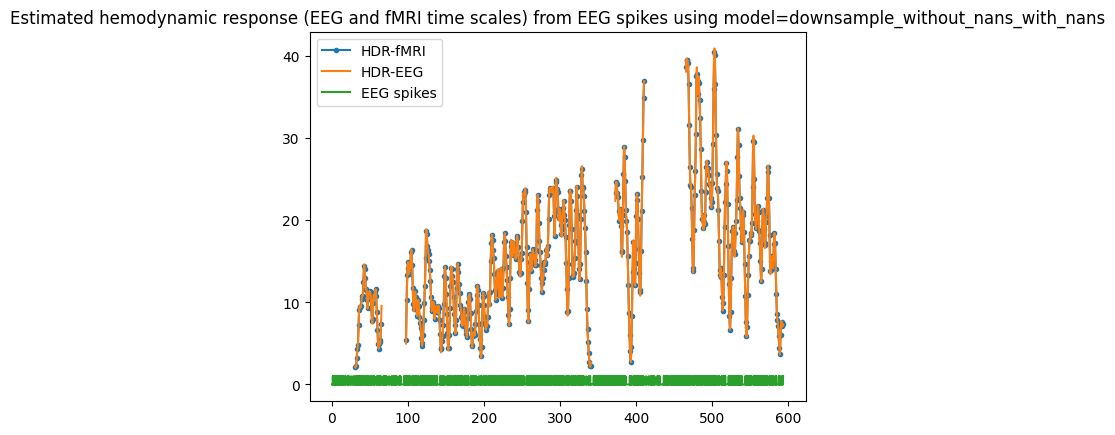

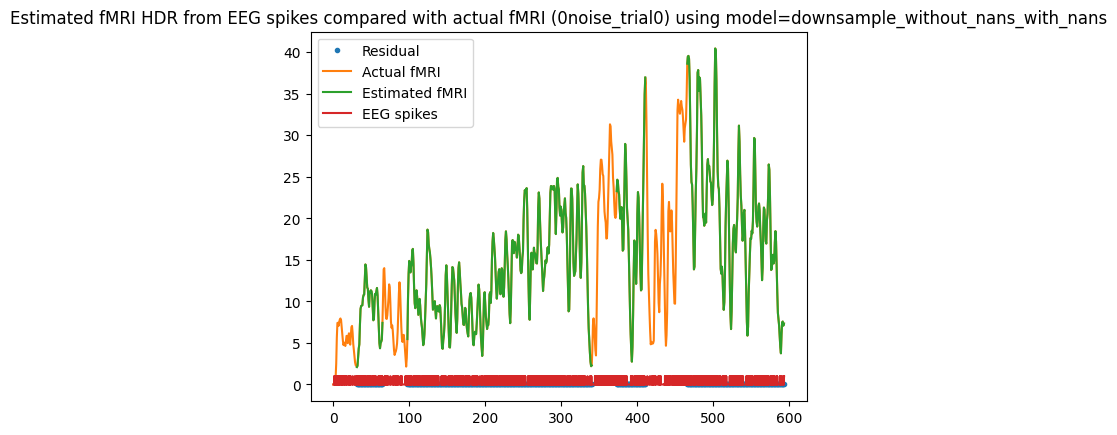

Residual Variance is 0.000000


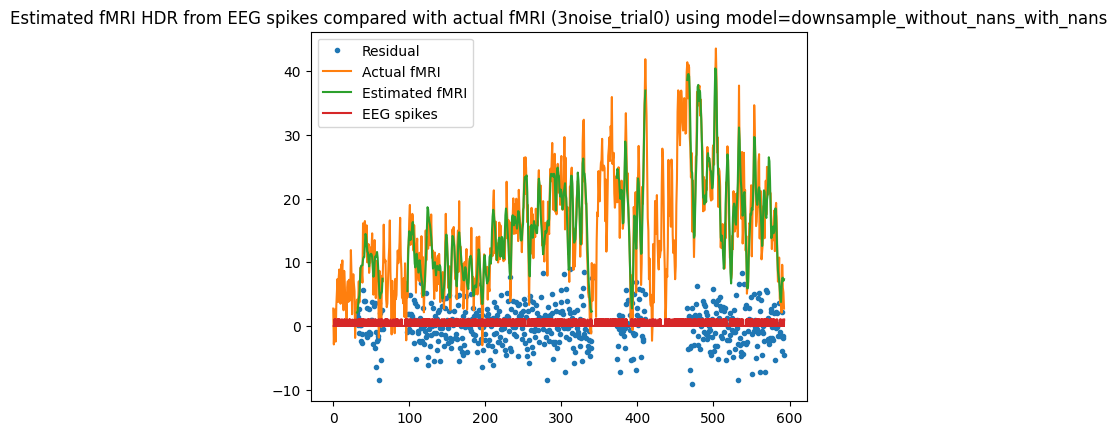

Residual Variance is 9.673055


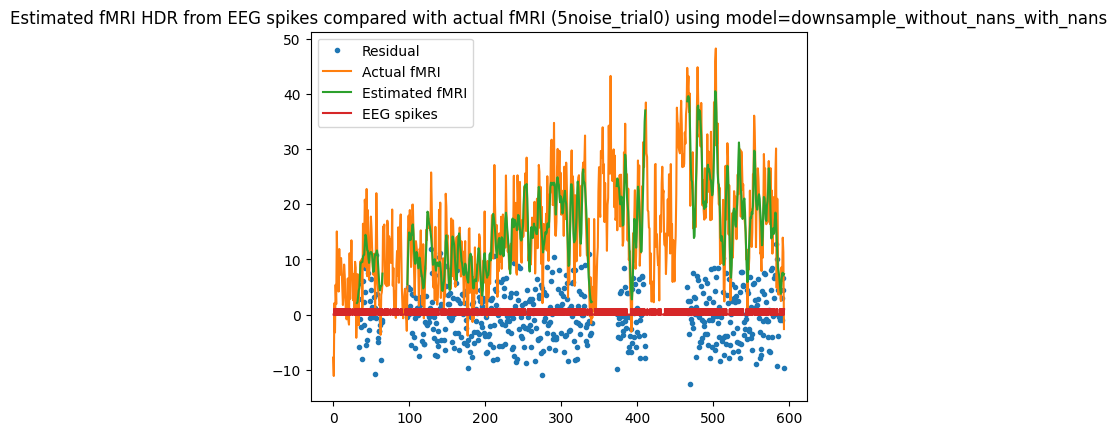

Residual Variance is 22.401192


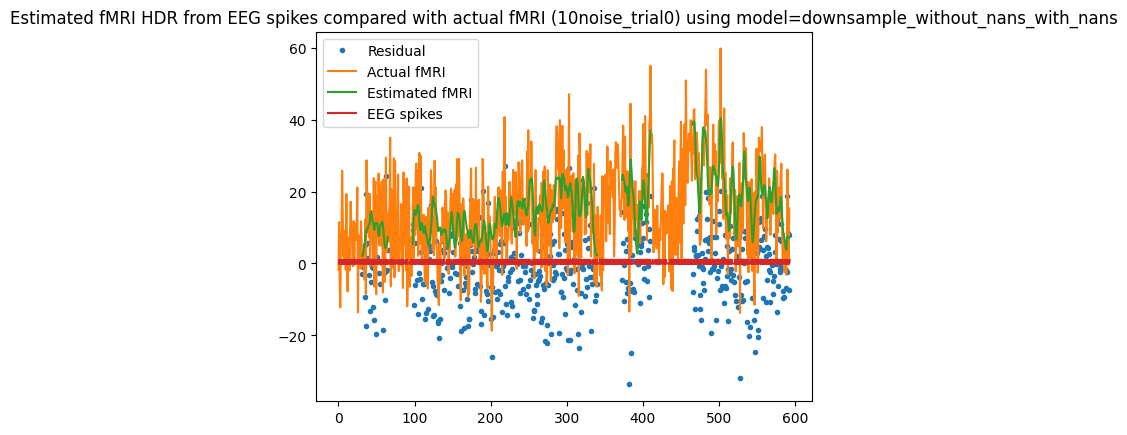

Residual Variance is 100.437428


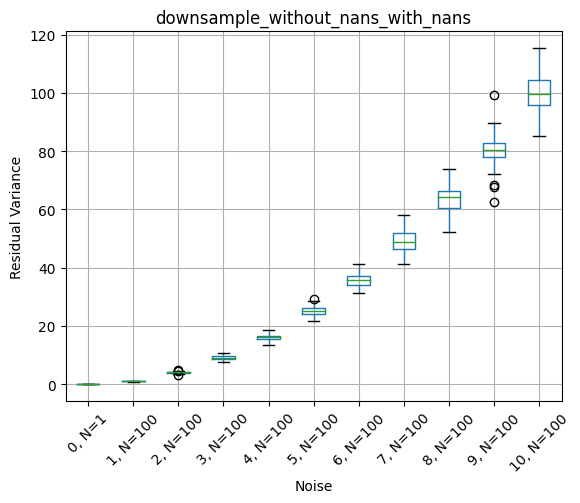

In [7]:
models = build_models(
    model_to_fmri,
    eeg_data_options_for_simulation,
    tr, 
    n_trs_skipped_at_beginning,
    sample_freq,
    hemodynamic_response_window,
    plot
)

# Get in-depth plots for actual delta, tau, alpha
for model_name, model in models.items():
    residual_var = model.score(expected_delta, expected_tau, expected_alpha)
    fmri_names = np.array(model.fmri.voxel_names)
    if (fmri_names == None).any():
        print(f'Residual variance was {residual_var}')
    else:
        noise_levels = np.char.replace(fmri_names, 'perfect', '0noise_trail0')
        noise_levels = np.char.partition(noise_levels, sep='noise')
        res_var_df = pd.DataFrame(zip(noise_levels[:,0].astype(int), residual_var), columns=['Noise', 'res_var'])
        res_var_by_noise = res_var_df.groupby('Noise')
        _, axs = plt.subplots()
        axs.set_title(model_name)
        axs.set_ylabel('Residual Variance')
        axs.set_xlabel('Noise')
        axs = res_var_by_noise.boxplot(column='res_var', subplots=False, rot=45, ax=axs)
        labels = res_var_by_noise.count()
        labels = [f'{noise}, N={n.item()}' for noise, n in zip(labels.index, labels.values)]
        plt.setp(axs, xticklabels=labels)
        plt.show()
    model.plot = False

## Generate/Load the full dataset

In [8]:
# Optional Reuse functionality

df = pd.DataFrame()
descriptions = []

if try_to_reuse:
    matching_files = sorted(glob.glob(f'{filename_substring}*{filename_ext}'))
    filename_to_use = "none"
    if len(matching_files) != 0:
        filename_to_use = input(
            f'Found previously run data. Enter name to reuse or "none" to recalculate.'
            f'\n{matching_files}\nDefault ({matching_files[-1]})\n'
        )
    if filename_to_use.lower() != "none":
        if filename_to_use.strip() == '':
            filename_to_use = matching_files[-1]
        print(f'Loading data from {filename_to_use}...')
        with open(filename_to_use, 'r') as f:
            df = pd.read_csv(f, index_col=0)
        descriptions = generate_descriptions_from_search_df(df, models)


In [9]:
if df.empty:
    if submit_to_cluster:
        raise NotImplemented("Submitting to the cluster is not implemented!")
    print('Generating data!')
    descriptions, df = search_voxels(models, delta, tau, alpha)
    with open(f'{filename_substring}_{datetime.now().strftime("%Y-%m-%d_%H:%M")}{filename_ext}', 'w') as f:
        pd.DataFrame(df).to_csv(f)
    for model_name, description in zip(models.keys(), descriptions):
        with open(f'{model_name}_summary_{filename_substring}_{datetime.now().strftime("%Y-%m-%d_%H:%M")}{filename_ext}', 'w') as f:
            pd.DataFrame(description).transpose().to_csv(f)

df

Generating data!
Scoring delta=1.0
Scoring delta=1.05
Scoring delta=1.1
Scoring delta=1.1500000000000001
Scoring delta=1.2000000000000002
Scoring delta=1.2500000000000002
Scoring delta=1.3000000000000003
Scoring delta=1.3500000000000003
Scoring delta=1.4000000000000004
Scoring delta=1.4500000000000004
Scoring delta=1.5000000000000004
Scoring delta=1.5500000000000005
Scoring delta=1.6000000000000005
Scoring delta=1.6500000000000006
Scoring delta=1.7000000000000006
Scoring delta=1.7500000000000007
Scoring delta=1.8000000000000007
Scoring delta=1.8500000000000008
Scoring delta=1.9000000000000008
Scoring delta=1.9500000000000008
Scoring delta=2.000000000000001
Scoring delta=2.0500000000000007
Scoring delta=2.100000000000001
Scoring delta=2.1500000000000012
Scoring delta=2.200000000000001
Scoring delta=2.250000000000001
Scoring delta=2.300000000000001
Scoring delta=2.3500000000000014
Scoring delta=2.4000000000000012
Scoring delta=2.450000000000001
Scoring delta=2.5000000000000013
Scoring de

delta                 tau               alpha  \
0                     1.0                0.75                1.75   
1                     1.0                0.75                1.75   
2                     1.0                0.75                 1.8   
3                     1.0                0.75                 1.8   
4                     1.0                0.75                1.85   
...                   ...                 ...                 ...   
18937  3.0000000000000018  1.7500000000000009  2.1500000000000004   
18938  3.0000000000000018  1.7500000000000009                 2.2   
18939  3.0000000000000018  1.7500000000000009                 2.2   
18940  3.0000000000000018  1.7500000000000009  2.2500000000000004   
18941  3.0000000000000018  1.7500000000000009  2.2500000000000004   

                                 model_name       0noise_trial0  \
0      downsample_without_nans_without_nans  10.959367109977032   
1         downsample_without_nans_with_nans  10.215750964321678   
2      downsample_without_nans_without_nans  10.254501827744386   
3         downsample_without_nans_with_nans    9.55581624790339   
4      downsample_without_nans_without_nans   9.576619599686264   
...                                     ...                 ...   
18937     downsample_without_nans_with_nans  29.271166155454942   
18938  downsample_without_nans_without_nans  32.107483852582995   
18939     downsample_without_nans_with_nans  29.658229906251897   
18940  downsample_without_nans_without_nans   32.56553535000221   
18941     downsample_without_nans_with_nans  30.031853432835103   

            1noise_trial0       2noise_trial0       3noise_trial0  \
0      12.324345007861064  14.019588196487053   20.31481136998487   
1       11.71075712045526  13.655660437132088  19.621088135932254   
2      11.601358293597418  13.334102245508673  19.594325425478388   
3      11.036108138878916  13.000662952095881  18.969710925741534   
4       10.90556578104105   12.67504655949844   18.90080519533166   
...                   ...                 ...                 ...   
18937  29.966182443453537   32.60956493157148  39.481016391994224   
18938  33.197792877702355   35.23922877757868   43.22332636555424   
18939  30.356395988298647   33.00015758008384    39.8534216588939   
18940   33.65943405283667   35.69067579502661   43.68214916117285   
18941  30.733087585437065   33.37699415003697   40.21160119959575   

            4noise_trial0      5noise_trial0  ...      1noise_trial99  \
0      26.826379757739826  33.05866478321512  ...  11.864951308773842   
1       27.03440115193899  33.03427329992251  ...   10.81321616331399   
2      26.120220111845473  32.35645737007759  ...  11.161492091422334   
3      26.340608083870364  32.37423655355593  ...  10.162109431882646   
4      25.438775036720994  31.68171157008674  ...  10.485776680036881   
...                   ...                ...  ...                 ...   
18937   45.80295829917724  54.48241844662454  ...  30.670895600305496   
18938  47.207383202755786  56.26684882571949  ...   33.49634054823743   
18939   46.21073872086304  54.90698028643076  ...   31.04177306796124   
18940  47.642603012766436  56.73499432143974  ...   33.94701247941118   
18941   46.60431163665733  55.31671444162528  ...  31.399232078349637   

           2noise_trial99      3noise_trial99      4noise_trial99  \
0      15.191118376338403  20.798744546187418   26.97498473087679   
1      14.069676403893174  19.414925061128148  26.938527026596788   
2      14.505171323573313  20.126361157924542  26.273825106984667   
3      13.446866547259523  18.801216004487433   26.29462280339942   
4      13.844229748073355  19.479650690538733   25.60161499531061   
...                   ...                 ...                 ...   
18937   32.25182572861623   38.27597777994466   46.33270353435683   
18938   35.40631883113246   40.96868098143953    49.4930610392286   
18939  32.620918840185006   38.66974468843437   46.76173736

## No Noise Analysis - downsample without missing data

### Cost

Minimal Cost for Average Cost: noise 0 (downsample_without_nans_without_nans) = 1.597844759335552e-29; at
     delta   tau  alpha
220    1.0  1.25   1.75


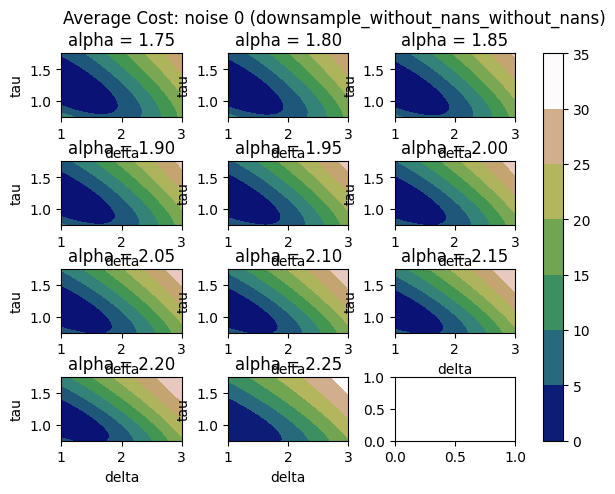

delta   tau  alpha  \
0        1.0  0.75   1.75   
2        1.0  0.75   1.80   
4        1.0  0.75   1.85   
6        1.0  0.75   1.90   
8        1.0  0.75   1.95   
...      ...   ...    ...   
18932    3.0  1.75   2.05   
18934    3.0  1.75   2.10   
18936    3.0  1.75   2.15   
18938    3.0  1.75   2.20   
18940    3.0  1.75   2.25   

       Average Cost: noise 0 (downsample_without_nans_without_nans)  
0                                              10.959367             
2                                              10.254502             
4                                               9.576620             
6                                               8.925901             
8                                               8.302487             
...                                                  ...             
18932                                          30.651074             
18934                                          31.150312             
18936                                          31.635768             
18938                                          32.107484             
18940                                          32.565535             

[9471 rows x 4 columns]

In [10]:
model_name = 'downsample_without_nans_without_nans'
noise = 0
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
columns_for_noise = df_to_plot.columns[columns_to_choose]

average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]

average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
plot_all_search_results_2d(average_df, separate_by='alpha')
average_df


In [11]:
data = []

minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()

for point in zip(*np.where(~np.isnan(minimum_cost_array))):
    row_of_interest = df_to_plot.iloc[point[0]]
    data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha']])
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
pd.DataFrame(data, columns=['delta', 'tau', 'alpha'])

Delta target: 1, Tau target: 1.25, Alpha target: 1.75


delta   tau  alpha
0    1.0  1.25   1.75

### Local Minima Analysis

In [12]:
delta_unique_values = df_to_plot['delta'].unique()    
tau_unique_values = df_to_plot['tau'].unique()
alpha_unique_values = df_to_plot['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(df_to_plot['delta'].values, new_shape)
tau_pts = np.reshape(df_to_plot['tau'].values, new_shape)
alpha_pts = np.reshape(df_to_plot['alpha'].values, new_shape)

# Find local minima
columns = df_to_plot.columns.drop(['delta', 'tau', 'alpha'])

m = np.reshape(
    df_to_plot[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
noise = 0

columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
for point in local_minima_with_given_noise:
    point_as_list = tuple(point.tolist())
    local_minima.append({
        'noise': noise,
        'iteration': columns[point[-1]].split('trial')[-1],
        'cost': m[point_as_list],
        'delta': delta_pts[point_as_list[:-1]],
        'tau': tau_pts[point_as_list[:-1]],
        'alpha': alpha_pts[point_as_list[:-1]]
    })

local_minima_by_noise = pd.DataFrame(local_minima)
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
local_minima_by_noise

Delta target: 1, Tau target: 1.25, Alpha target: 1.75


noise iteration          cost  delta   tau  alpha
0      0         0  3.603056e-02    1.0  1.15   1.95
1      0         0  9.314761e-03    1.0  1.20   1.85
2      0         0  1.597845e-29    1.0  1.25   1.75

In [13]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').mean()

Number of Local Minima
noise                        
0                         3.0

#### Local minima at edges

In [14]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

noise iteration          cost  delta   tau  alpha
0      0         0  3.603056e-02    1.0  1.15   1.95
1      0         0  9.314761e-03    1.0  1.20   1.85
2      0         0  1.597845e-29    1.0  1.25   1.75

In [15]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [16]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [17]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [18]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

noise iteration          cost  delta   tau  alpha
2      0         0  1.597845e-29    1.0  1.25   1.75

In [19]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

## No Noise Analysis - downsample with missing data

### Cost

Minimal Cost for Average Cost: noise 0 (downsample_without_nans_with_nans) = 5.136215580174909e-28; at
     delta   tau  alpha
221    1.0  1.25   1.75


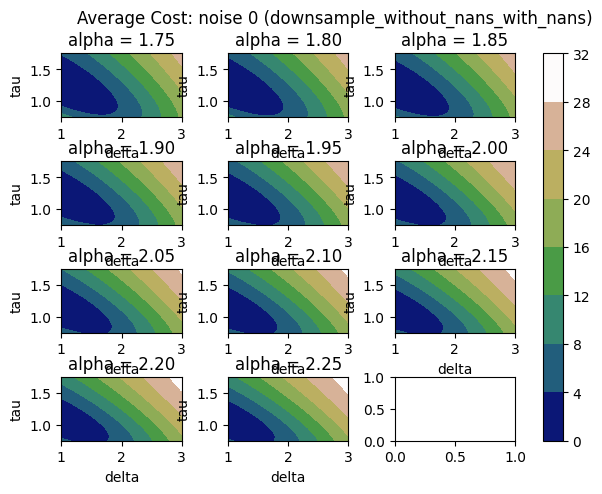

delta   tau  alpha  \
1        1.0  0.75   1.75   
3        1.0  0.75   1.80   
5        1.0  0.75   1.85   
7        1.0  0.75   1.90   
9        1.0  0.75   1.95   
...      ...   ...    ...   
18933    3.0  1.75   2.05   
18935    3.0  1.75   2.10   
18937    3.0  1.75   2.15   
18939    3.0  1.75   2.20   
18941    3.0  1.75   2.25   

       Average Cost: noise 0 (downsample_without_nans_with_nans)  
1                                              10.215751          
3                                               9.555816          
5                                               8.921051          
7                                               8.311643          
9                                               7.727748          
...                                                  ...          
18933                                          28.456141          
18935                                          28.870510          
18937                                          29.271166          
18939                                          29.658230          
18941                                          30.031853          

[9471 rows x 4 columns]

In [20]:
model_name = 'downsample_without_nans_with_nans'
noise = 0
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
columns_for_noise = df_to_plot.columns[columns_to_choose]

average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]

average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
plot_all_search_results_2d(average_df, separate_by='alpha')
average_df


In [21]:
data = []

minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()

for point in zip(*np.where(~np.isnan(minimum_cost_array))):
    row_of_interest = df_to_plot.iloc[point[0]]
    data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha']])
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
pd.DataFrame(data, columns=['delta', 'tau', 'alpha'])

Delta target: 1, Tau target: 1.25, Alpha target: 1.75


delta   tau  alpha
0    1.0  1.25   1.75

### Local Minima Analysis

In [22]:
delta_unique_values = df_to_plot['delta'].unique()    
tau_unique_values = df_to_plot['tau'].unique()
alpha_unique_values = df_to_plot['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(df_to_plot['delta'].values, new_shape)
tau_pts = np.reshape(df_to_plot['tau'].values, new_shape)
alpha_pts = np.reshape(df_to_plot['alpha'].values, new_shape)

# Find local minima
columns = df_to_plot.columns.drop(['delta', 'tau', 'alpha'])

m = np.reshape(
    df_to_plot[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
noise = 0

columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
for point in local_minima_with_given_noise:
    point_as_list = tuple(point.tolist())
    local_minima.append({
        'noise': noise,
        'iteration': columns[point[-1]].split('trial')[-1],
        'cost': m[point_as_list],
        'delta': delta_pts[point_as_list[:-1]],
        'tau': tau_pts[point_as_list[:-1]],
        'alpha': alpha_pts[point_as_list[:-1]]
    })

local_minima_by_noise = pd.DataFrame(local_minima)
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
local_minima_by_noise

Delta target: 1, Tau target: 1.25, Alpha target: 1.75


noise iteration          cost  delta   tau  alpha
0      0         0  3.518032e-02    1.0  1.15   1.95
1      0         0  9.171279e-03    1.0  1.20   1.85
2      0         0  5.136216e-28    1.0  1.25   1.75

In [23]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').mean()

Number of Local Minima
noise                        
0                         3.0

#### Local minima at edges

In [24]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

noise iteration          cost  delta   tau  alpha
0      0         0  3.518032e-02    1.0  1.15   1.95
1      0         0  9.171279e-03    1.0  1.20   1.85
2      0         0  5.136216e-28    1.0  1.25   1.75

In [25]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [26]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [27]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [28]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

noise iteration          cost  delta   tau  alpha
2      0         0  5.136216e-28    1.0  1.25   1.75

In [29]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

## Cost by Noise

### Downsample without Missing Data

Minimal Cost for Average Cost: noise 1 (downsample_without_nans_without_nans) = 0.999961414156543; at
     delta   tau  alpha
220    1.0  1.25   1.75


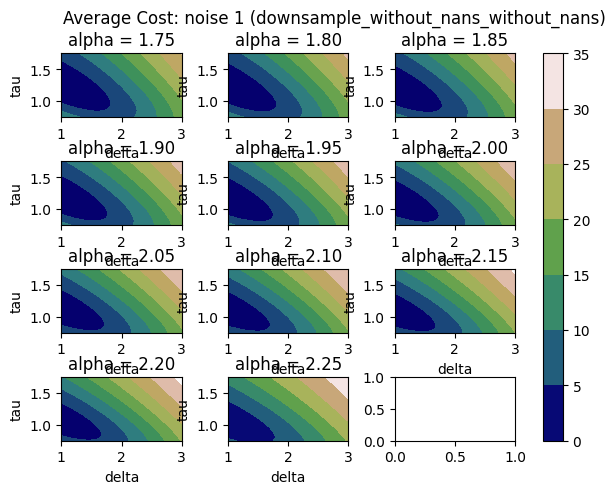

Minimal Cost for Average Cost: noise 2 (downsample_without_nans_without_nans) = 4.017980180885732; at
     delta   tau  alpha
220    1.0  1.25   1.75


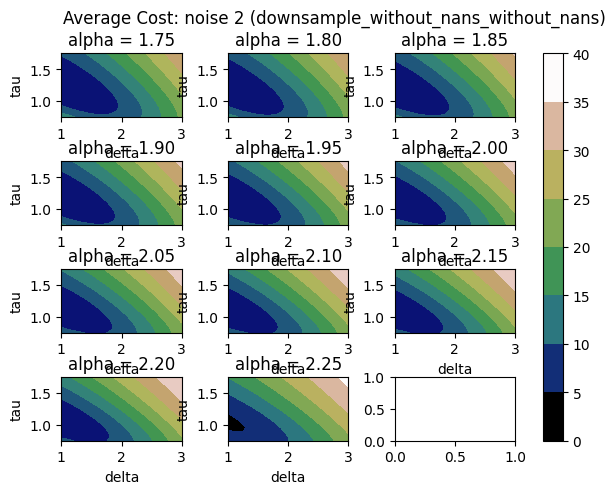

Minimal Cost for Average Cost: noise 3 (downsample_without_nans_without_nans) = 9.037897709997925; at
     delta   tau  alpha
220    1.0  1.25   1.75


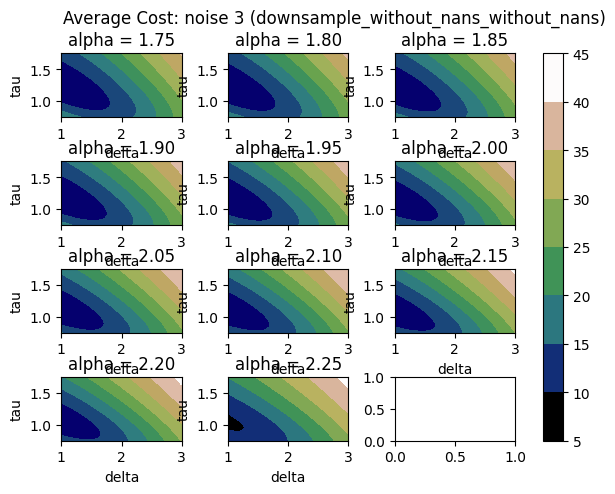

Minimal Cost for Average Cost: noise 4 (downsample_without_nans_without_nans) = 16.055214518649528; at
     delta   tau  alpha
220    1.0  1.25   1.75


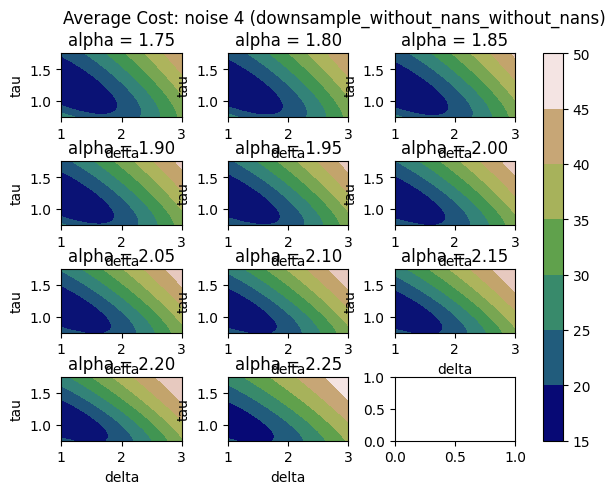

Minimal Cost for Average Cost: noise 5 (downsample_without_nans_without_nans) = 25.059033679884102; at
     delta   tau  alpha
220    1.0  1.25   1.75


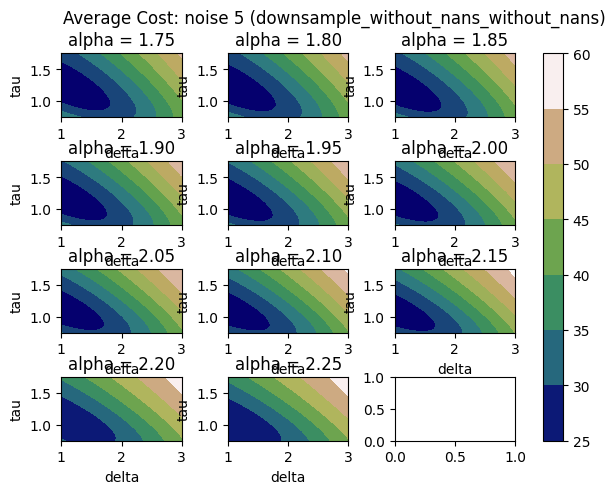

Minimal Cost for Average Cost: noise 6 (downsample_without_nans_without_nans) = 35.84799054499062; at
     delta   tau  alpha
220    1.0  1.25   1.75


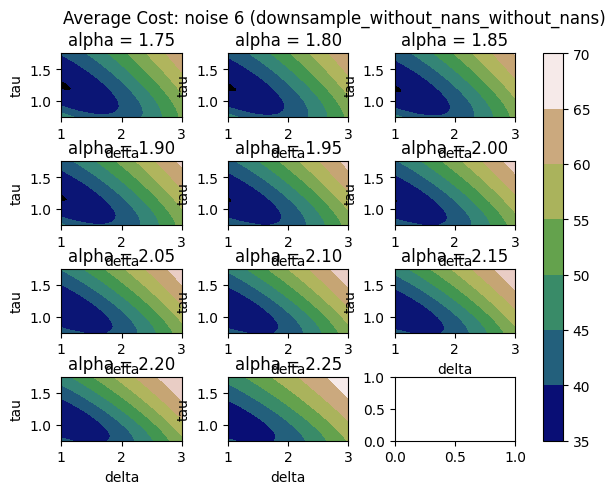

Minimal Cost for Average Cost: noise 7 (downsample_without_nans_without_nans) = 48.884849696407535; at
     delta   tau  alpha
220    1.0  1.25   1.75


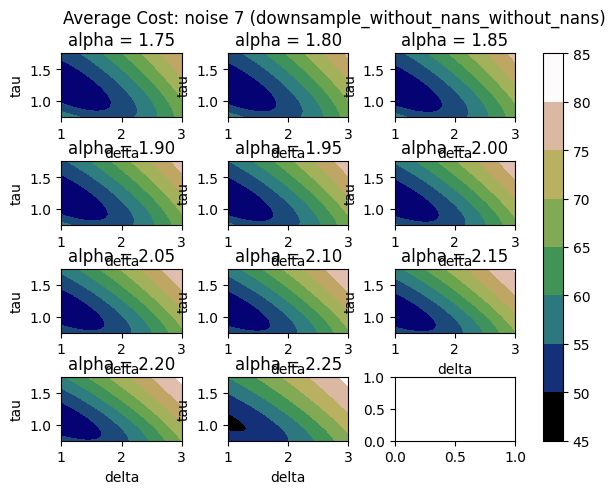

Minimal Cost for Average Cost: noise 8 (downsample_without_nans_without_nans) = 63.9046370451667; at
     delta   tau  alpha
220    1.0  1.25   1.75


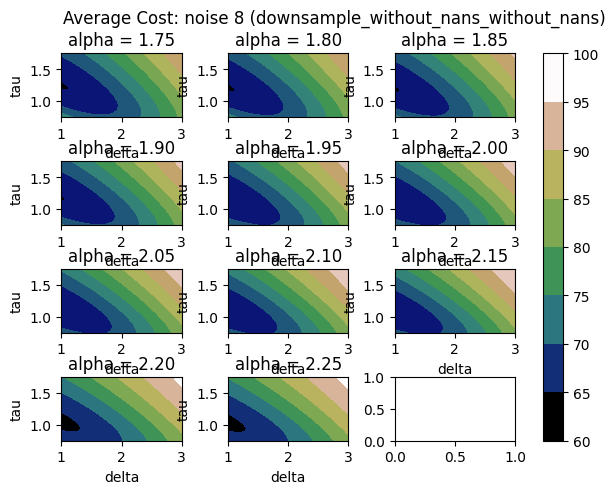

Minimal Cost for Average Cost: noise 9 (downsample_without_nans_without_nans) = 80.49241423825498; at
     delta   tau  alpha
220    1.0  1.25   1.75


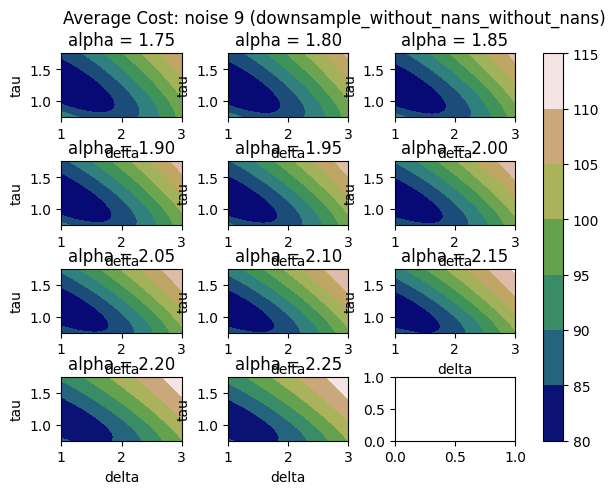

Minimal Cost for Average Cost: noise 10 (downsample_without_nans_without_nans) = 99.64798033157466; at
     delta   tau  alpha
220    1.0  1.25   1.75


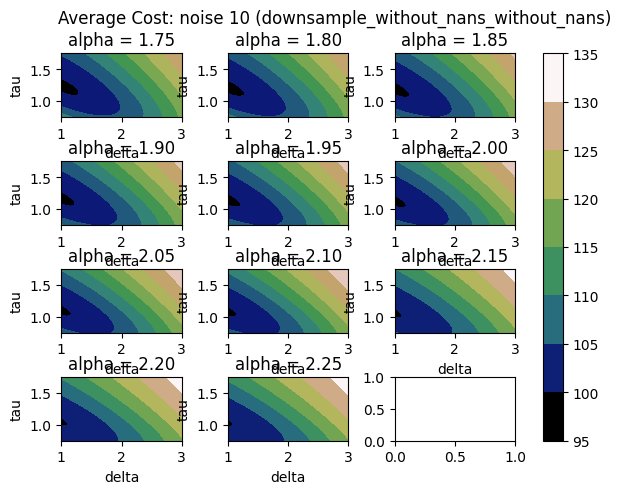

In [30]:
model_name = 'downsample_without_nans_without_nans'
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]

    average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]
    average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
    plot_all_search_results_2d(average_df, separate_by='alpha')

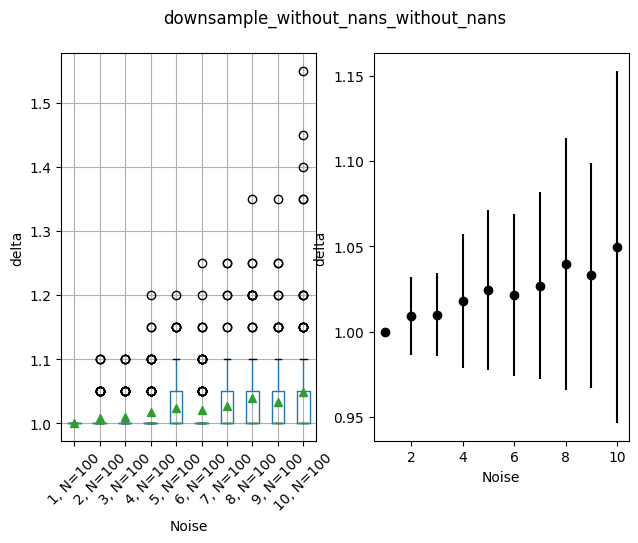

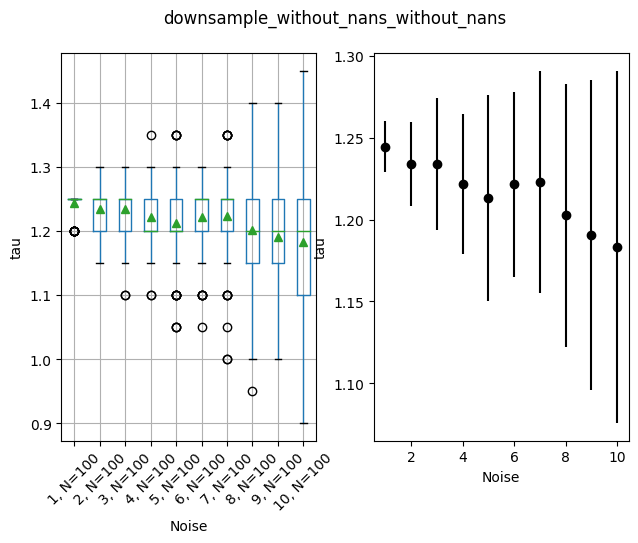

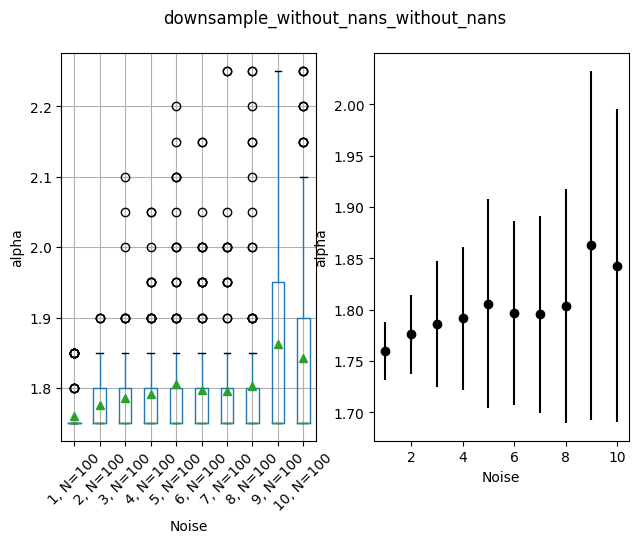

In [31]:
data = []
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]
    minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
    minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()
    
    for point in zip(*np.where(~np.isnan(minimum_cost_array))):
        row_of_interest = df_to_plot.iloc[point[0]]
        data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha'], noise])

chosen_points = pd.DataFrame(data, columns=['delta', 'tau', 'alpha', 'noise']).groupby('noise')

for variable in ['delta', 'tau', 'alpha']:
    fig, axs = plt.subplots(1, 2)
    fig.suptitle(model_name)
    fig.tight_layout()
    axs[0].set_ylabel(variable)
    axs[0].set_xlabel('Noise')
    axs[0] = chosen_points.boxplot(subplots=False, column=variable, rot=45, ax=axs[0], showmeans=True)
    axs[1].set_ylabel(variable)
    axs[1].set_xlabel('Noise')
    axs[1].errorbar(noise_range, chosen_points.mean()[variable], chosen_points.std()[variable], fmt='ok')
    labels = chosen_points.count()
    labels = [f'{noise}, N={n[0].item()}' for noise, n in zip(labels.index, labels.values)]
    plt.setp(axs[0], xticklabels=labels)
    plt.show()

### Downsample with Missing Data

Minimal Cost for Average Cost: noise 1 (downsample_without_nans_with_nans) = 0.9985358604215284; at
     delta   tau  alpha
221    1.0  1.25   1.75


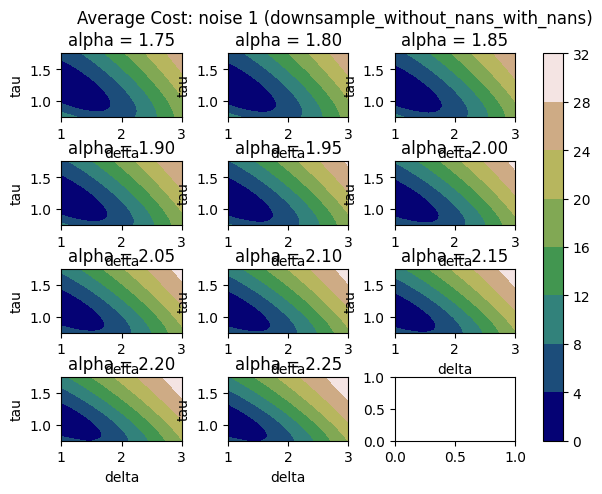

Minimal Cost for Average Cost: noise 2 (downsample_without_nans_with_nans) = 4.026185894402587; at
     delta   tau  alpha
221    1.0  1.25   1.75


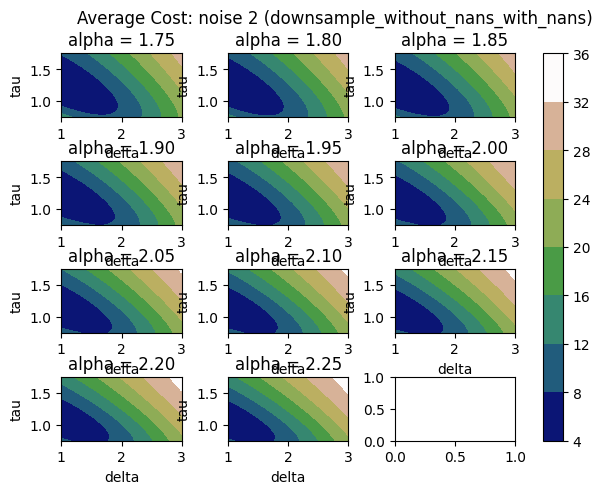

Minimal Cost for Average Cost: noise 3 (downsample_without_nans_with_nans) = 9.064056937714284; at
     delta   tau  alpha
221    1.0  1.25   1.75


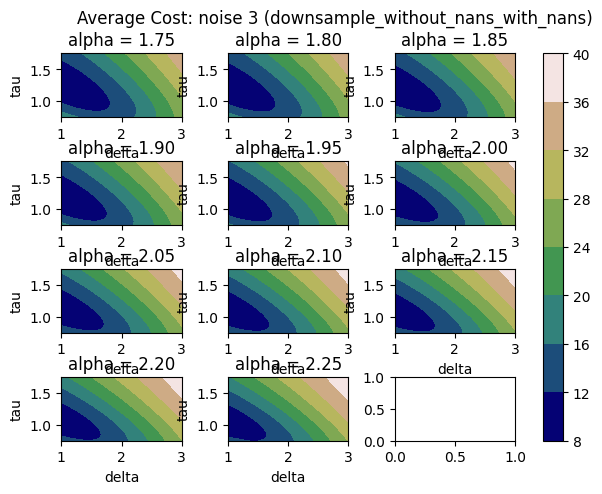

Minimal Cost for Average Cost: noise 4 (downsample_without_nans_with_nans) = 16.098448207575526; at
     delta   tau  alpha
221    1.0  1.25   1.75


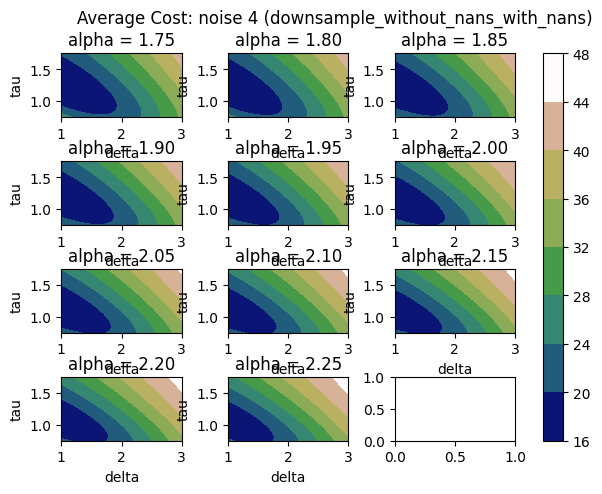

Minimal Cost for Average Cost: noise 5 (downsample_without_nans_with_nans) = 25.09931671925897; at
     delta   tau  alpha
221    1.0  1.25   1.75


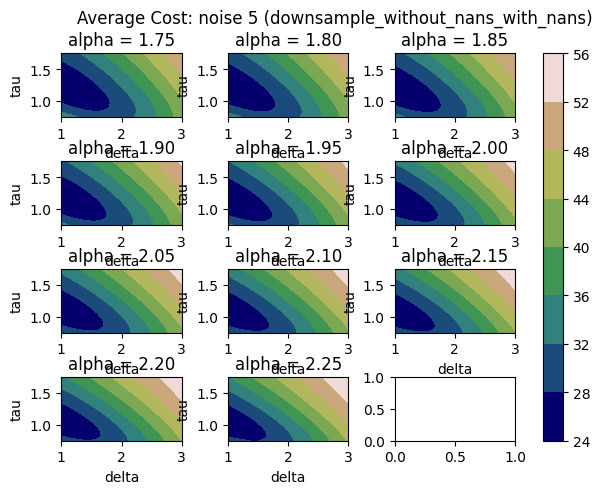

Minimal Cost for Average Cost: noise 6 (downsample_without_nans_with_nans) = 35.76445031872636; at
     delta   tau  alpha
221    1.0  1.25   1.75


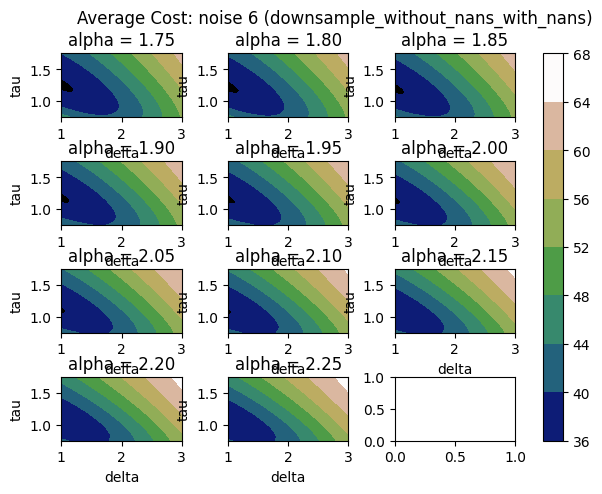

Minimal Cost for Average Cost: noise 7 (downsample_without_nans_with_nans) = 49.0457132424633; at
     delta   tau  alpha
221    1.0  1.25   1.75


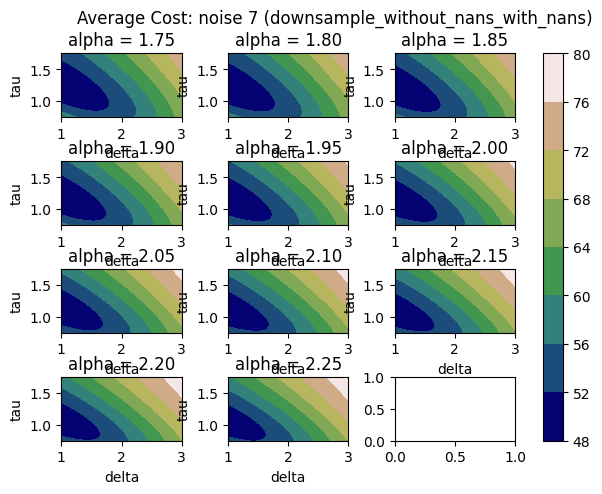

Minimal Cost for Average Cost: noise 8 (downsample_without_nans_with_nans) = 63.84467328179362; at
     delta   tau  alpha
221    1.0  1.25   1.75


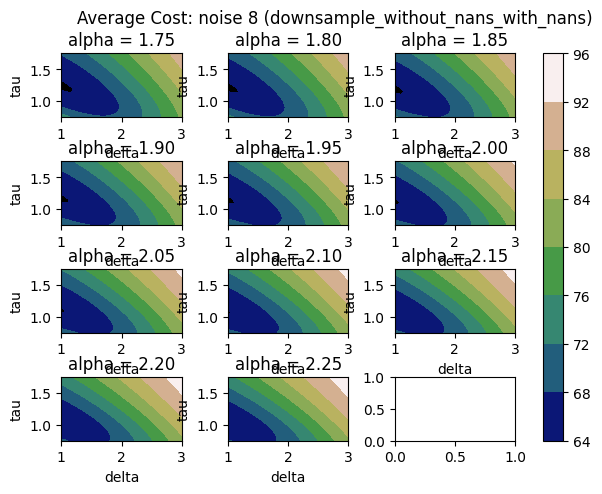

Minimal Cost for Average Cost: noise 9 (downsample_without_nans_with_nans) = 80.27032592747452; at
     delta   tau  alpha
221    1.0  1.25   1.75


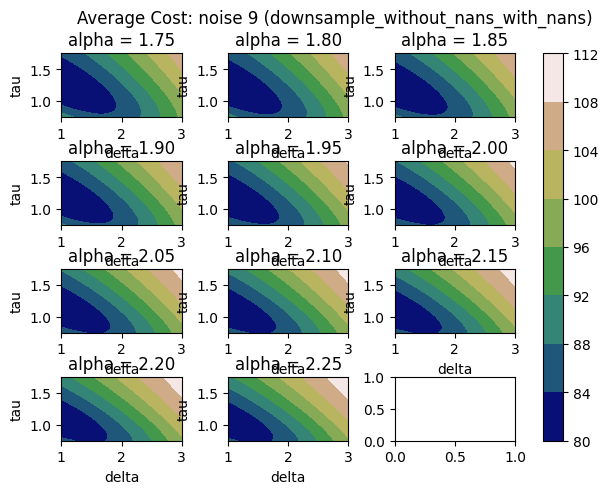

Minimal Cost for Average Cost: noise 10 (downsample_without_nans_with_nans) = 99.97186226933756; at
     delta  tau  alpha
201    1.0  1.2    1.8


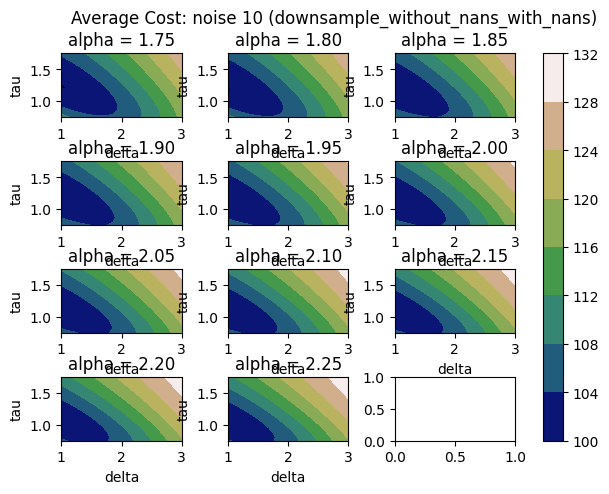

In [32]:
model_name = 'downsample_without_nans_with_nans'
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]

    average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]
    average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
    plot_all_search_results_2d(average_df, separate_by='alpha')


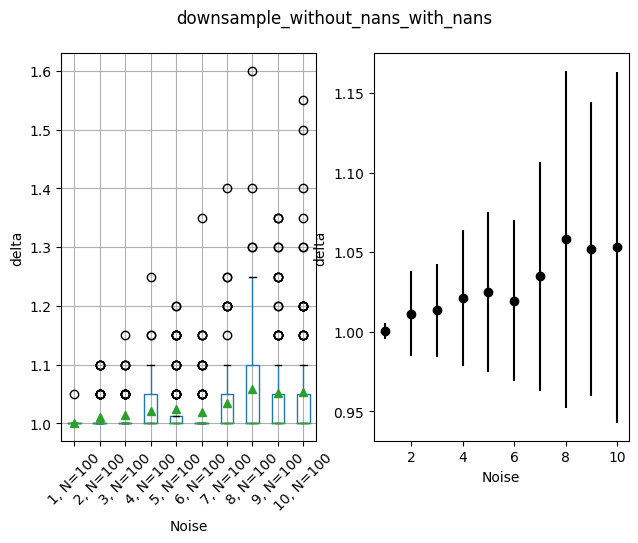

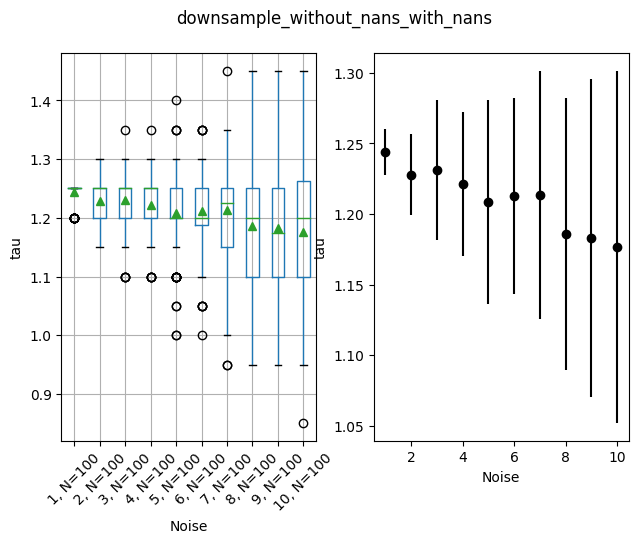

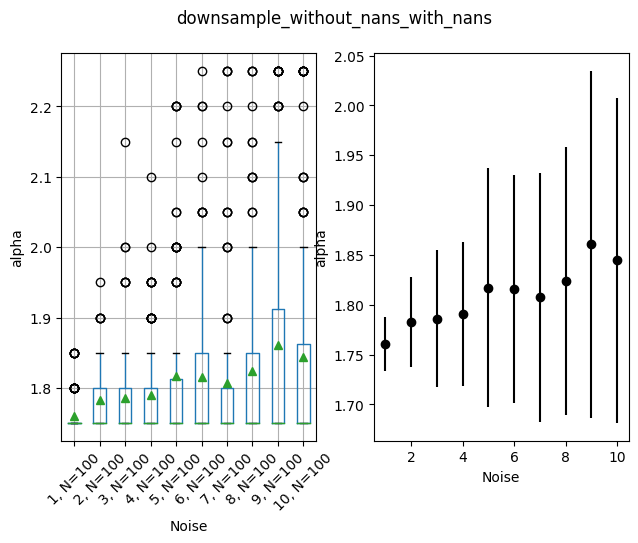

In [33]:
data = []
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]
    minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
    minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()
    
    for point in zip(*np.where(~np.isnan(minimum_cost_array))):
        row_of_interest = df_to_plot.iloc[point[0]]
        data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha'], noise])

chosen_points = pd.DataFrame(data, columns=['delta', 'tau', 'alpha', 'noise']).groupby('noise')

for variable in ['delta', 'tau', 'alpha']:
    fig, axs = plt.subplots(1, 2)
    fig.suptitle(model_name)
    fig.tight_layout()
    axs[0].set_ylabel(variable)
    axs[0].set_xlabel('Noise')
    axs[0] = chosen_points.boxplot(subplots=False, column=variable, rot=45, ax=axs[0], showmeans=True)
    axs[1].set_ylabel(variable)
    axs[1].set_xlabel('Noise')
    axs[1].errorbar(noise_range, chosen_points.mean()[variable], chosen_points.std()[variable], fmt='ok')
    labels = chosen_points.count()
    labels = [f'{noise}, N={n[0].item()}' for noise, n in zip(labels.index, labels.values)]
    plt.setp(axs[0], xticklabels=labels)
    plt.show()

## Local Minima Analysis

### Downsample without missing data

In [34]:
model = df['model_name'].unique()[0]
print(f"For Model '{model}'")
portion_df = df[df['model_name'] == model].drop(columns='model_name')
delta_unique_values = portion_df['delta'].unique()    
tau_unique_values = portion_df['tau'].unique()
alpha_unique_values = portion_df['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(portion_df['delta'].values, new_shape)
tau_pts = np.reshape(portion_df['tau'].values, new_shape)
alpha_pts = np.reshape(portion_df['alpha'].values, new_shape)

For Model 'downsample_without_nans_without_nans'


In [35]:
# Find local minima
columns = portion_df.columns.drop(['delta', 'tau', 'alpha'])
     
m = np.reshape(
    portion_df[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

In [36]:
local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
for noise in noise_range:
    columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
    local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
    for point in local_minima_with_given_noise:
        point_as_list = tuple(point.tolist())
        local_minima.append({
            'noise': noise,
            'iteration': columns[point[-1]].split('trial')[-1],
            'cost': m[point_as_list],
            'delta': delta_pts[point_as_list[:-1]],
            'tau': tau_pts[point_as_list[:-1]],
            'alpha': alpha_pts[point_as_list[:-1]]
        })

local_minima_by_noise = pd.DataFrame(local_minima)
local_minima_by_noise


noise iteration        cost               delta                 tau  \
0         1        10    1.093868                 1.0  1.1000000000000003   
1         1        11    1.028691                 1.0  1.1000000000000003   
2         1        28    1.058672                 1.0  1.1000000000000003   
3         1        52    0.976825                 1.0  1.1000000000000003   
4         1        65    1.043922                 1.0  1.1000000000000003   
...     ...       ...         ...                 ...                 ...   
1918     10        36  102.435727  1.3500000000000003  1.1500000000000004   
1919     10        93   96.972658  1.4000000000000004  1.1000000000000003   
1920     10        92   94.036252  1.4500000000000004  0.9500000000000002   
1921     10         1  103.806402  1.4500000000000004  1.1500000000000004   
1922     10         2  100.643458  1.5500000000000005  1.0500000000000003   

                   alpha  
0     2.0500000000000003  
1     2.0500000000000003  
2     2.0500000000000003  
3     2.0500000000000003  
4     2.0500000000000003  
...                  ...  
1918                1.75  
1919                 1.8  
1920                1.75  
1921                1.75  
1922                1.75  

[1923 rows x 6 columns]

In [37]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').describe()

Number of Local Minima                                         
                       count  mean       std  min  25%  50%  75%  max
noise                                                                
1                      100.0  2.07  0.901794  1.0  1.0  2.0  3.0  4.0
2                      100.0  1.92  0.895330  1.0  1.0  2.0  3.0  4.0
3                      100.0  1.77  0.951925  1.0  1.0  1.0  3.0  4.0
4                      100.0  1.93  1.007597  1.0  1.0  2.0  3.0  4.0
5                      100.0  2.10  1.132620  1.0  1.0  2.0  3.0  4.0
6                      100.0  1.81  1.070212  1.0  1.0  1.0  3.0  5.0
7                      100.0  1.89  1.136137  1.0  1.0  1.0  3.0  4.0
8                      100.0  1.93  1.139333  1.0  1.0  1.0  3.0  4.0
9                      100.0  1.92  1.125283  1.0  1.0  1.0  3.0  4.0
10                     100.0  1.89  1.062634  1.0  1.0  1.0  3.0  4.0

#### Local minima at edges

In [38]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

noise iteration        cost delta                 tau  \
0         1        10    1.093868   1.0  1.1000000000000003   
1         1        11    1.028691   1.0  1.1000000000000003   
2         1        28    1.058672   1.0  1.1000000000000003   
3         1        52    0.976825   1.0  1.1000000000000003   
4         1        65    1.043922   1.0  1.1000000000000003   
...     ...       ...         ...   ...                 ...   
1853     10        44   92.653949   1.0  1.3500000000000005   
1854     10        57   97.219883   1.0  1.3500000000000005   
1855     10        87   96.502360   1.0  1.3500000000000005   
1856     10        97  102.338142   1.0  1.4000000000000006   
1857     10        91  102.525507   1.0  1.4500000000000006   

                   alpha  
0     2.0500000000000003  
1     2.0500000000000003  
2     2.0500000000000003  
3     2.0500000000000003  
4     2.0500000000000003  
...                  ...  
1853                1.75  
1854                1.75  
1855                1.75  
1856                1.75  
1857                1.75  

[1523 rows x 6 columns]

In [39]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [40]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [41]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [42]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

noise iteration        cost               delta                 tau  \
115       1         0    1.041303                 1.0  1.2500000000000004   
116       1         1    1.071594                 1.0  1.2500000000000004   
117       1         2    0.964113                 1.0  1.2500000000000004   
118       1         3    0.951511                 1.0  1.2500000000000004   
119       1         4    1.094668                 1.0  1.2500000000000004   
...     ...       ...         ...                 ...                 ...   
1910     10        80   95.048410  1.2000000000000002  1.2000000000000004   
1918     10        36  102.435727  1.3500000000000003  1.1500000000000004   
1920     10        92   94.036252  1.4500000000000004  0.9500000000000002   
1921     10         1  103.806402  1.4500000000000004  1.1500000000000004   
1922     10         2  100.643458  1.5500000000000005  1.0500000000000003   

     alpha  
115   1.75  
116   1.75  
117   1.75  
118   1.75  
119   1.75  
...    ...  
1910  1.75  
1918  1.75  
1920  1.75  
1921  1.75  
1922  1.75  

[716 rows x 6 columns]

In [43]:
alpha_min.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

delta                    tau                                
      count unique  top freq count unique                 top freq
noise                                                             
1        91      1  1.0   91    91      1  1.2500000000000004   91
10       67      8  1.0   45    67     10  1.2000000000000004   17
2        70      3  1.0   57    70      3  1.2500000000000004   64
3        64      4  1.0   50    64      3  1.2500000000000004   47
4        70      5  1.0   49    70      5  1.2500000000000004   37
5        71      5  1.0   47    71      6  1.2500000000000004   30
6        75      5  1.0   55    75      6  1.2500000000000004   38
7        71      6  1.0   52    71      6  1.2500000000000004   25
8        77      7  1.0   53    77      8  1.2000000000000004   23
9        60      7  1.0   42    60      8  1.2000000000000004   16

In [44]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

noise iteration        cost               delta                 tau  \
399       3        26    9.058603                 1.0  1.0000000000000002   
400       3        77    8.919035                 1.0  1.0000000000000002   
408       3        56    9.643642                 1.0  1.0500000000000003   
576       4        76   16.990676                 1.0  1.0000000000000002   
585       4        35   15.902273                 1.0  1.0500000000000003   
...     ...       ...         ...                 ...                 ...   
1858     10        20  110.886230                1.05  0.9500000000000002   
1859     10        46  102.687298                1.05  0.9500000000000002   
1865     10        50  107.022005                1.05  1.1000000000000003   
1891     10        43   95.897785  1.1500000000000001  0.9500000000000002   
1905     10        59   97.935511  1.2000000000000002  0.9500000000000002   

                   alpha  
399   2.2500000000000004  
400   2.2500000000000004  
408   2.2500000000000004  
576   2.2500000000000004  
585   2.2500000000000004  
...                  ...  
1858  2.2500000000000004  
1859  2.2500000000000004  
1865  2.2500000000000004  
1891  2.2500000000000004  
1905  2.2500000000000004  

[71 rows x 6 columns]

In [45]:
alpha_max.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

delta                    tau                                
      count unique  top freq count unique                 top freq
noise                                                             
10       12      4  1.0    7    12      4  0.9500000000000002    5
3         3      1  1.0    3     3      2  1.0000000000000002    2
4         2      1  1.0    2     2      2  1.0000000000000002    1
5        12      1  1.0   12    12      2  1.0000000000000002    6
6         6      1  1.0    6     6      2  1.0500000000000003    4
7         9      3  1.0    7     9      3  1.0500000000000003    5
8        12      3  1.0    8    12      4  1.0500000000000003    5
9        15      3  1.0   11    15      3  1.0000000000000002    9

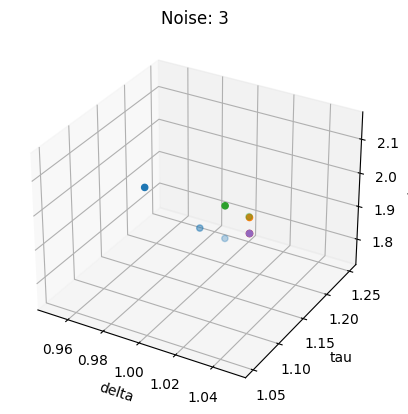

In [46]:
noise = 3
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

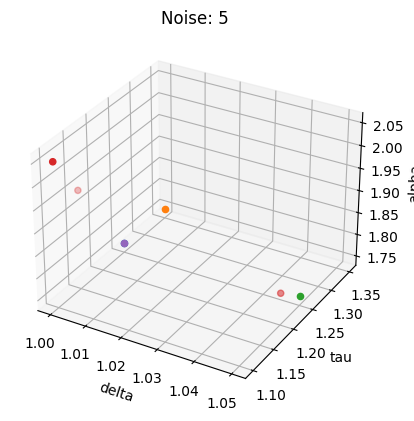

In [47]:
noise = 5
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

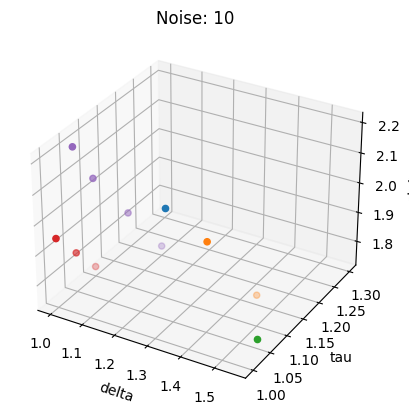

In [48]:
noise = 10
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

### Downsample with missing data

In [49]:
model = df['model_name'].unique()[1]
print(f"For Model '{model}'")
portion_df = df[df['model_name'] == model].drop(columns='model_name')
delta_unique_values = portion_df['delta'].unique()    
tau_unique_values = portion_df['tau'].unique()
alpha_unique_values = portion_df['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(portion_df['delta'].values, new_shape)
tau_pts = np.reshape(portion_df['tau'].values, new_shape)
alpha_pts = np.reshape(portion_df['alpha'].values, new_shape)

For Model 'downsample_without_nans_with_nans'


In [50]:
# Find local minima
columns = portion_df.columns.drop(['delta', 'tau', 'alpha'])
     
m = np.reshape(
    portion_df[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

In [51]:
local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
for noise in noise_range:
    columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
    local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
    for point in local_minima_with_given_noise:
        point_as_list = tuple(point.tolist())
        local_minima.append({
            'noise': noise,
            'iteration': columns[point[-1]].split('trial')[-1],
            'cost': m[point_as_list],
            'delta': delta_pts[point_as_list[:-1]],
            'tau': tau_pts[point_as_list[:-1]],
            'alpha': alpha_pts[point_as_list[:-1]]
        })

local_minima_by_noise = pd.DataFrame(local_minima)
local_minima_by_noise


noise iteration        cost               delta                 tau  \
0         1         5    1.028328                 1.0  1.1000000000000003   
1         1        14    1.163750                 1.0  1.1000000000000003   
2         1        24    0.979943                 1.0  1.1000000000000003   
3         1        37    0.996008                 1.0  1.1000000000000003   
4         1        48    0.976999                 1.0  1.1000000000000003   
...     ...       ...         ...                 ...                 ...   
1846     10        20  114.288484  1.4500000000000004  0.9500000000000002   
1847     10        20  114.283449  1.5000000000000004  0.9500000000000002   
1848     10         1  105.683979  1.5000000000000004  1.0500000000000003   
1849     10         1  105.683966  1.5000000000000004  1.1000000000000003   
1850     10         2  105.041971  1.5500000000000005  1.0000000000000002   

                   alpha  
0     2.0500000000000003  
1     2.0500000000000003  
2     2.0500000000000003  
3     2.0500000000000003  
4     2.0500000000000003  
...                  ...  
1846                1.85  
1847                1.75  
1848                1.85  
1849                1.75  
1850                1.75  

[1851 rows x 6 columns]

In [52]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').describe()

Number of Local Minima                                          
                       count  mean       std  min  25%  50%   75%  max
noise                                                                 
1                      100.0  2.01  0.893241  1.0  1.0  2.0  3.00  4.0
2                      100.0  2.01  0.969171  1.0  1.0  2.0  3.00  4.0
3                      100.0  1.81  0.950226  1.0  1.0  1.5  2.25  4.0
4                      100.0  1.87  1.041124  1.0  1.0  1.0  3.00  4.0
5                      100.0  1.79  0.945964  1.0  1.0  1.0  3.00  4.0
6                      100.0  1.85  1.048086  1.0  1.0  1.0  3.00  4.0
7                      100.0  1.75  1.028631  1.0  1.0  1.0  2.25  4.0
8                      100.0  1.76  1.035921  1.0  1.0  1.0  3.00  4.0
9                      100.0  1.85  1.076611  1.0  1.0  1.0  3.00  4.0
10                     100.0  1.81  1.098162  1.0  1.0  1.0  3.00  5.0

#### Local minima at edges

In [53]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

noise iteration        cost delta                 tau  \
0         1         5    1.028328   1.0  1.1000000000000003   
1         1        14    1.163750   1.0  1.1000000000000003   
2         1        24    0.979943   1.0  1.1000000000000003   
3         1        37    0.996008   1.0  1.1000000000000003   
4         1        48    0.976999   1.0  1.1000000000000003   
...     ...       ...         ...   ...                 ...   
1790     10        25  100.762656   1.0  1.4000000000000006   
1791     10        87  100.122776   1.0  1.4000000000000006   
1792     10        95  105.102266   1.0  1.4000000000000006   
1793     10        91  106.799994   1.0  1.4000000000000006   
1794     10        91  106.798461   1.0  1.4500000000000006   

                   alpha  
0     2.0500000000000003  
1     2.0500000000000003  
2     2.0500000000000003  
3     2.0500000000000003  
4     2.0500000000000003  
...                  ...  
1790                1.75  
1791                1.75  
1792                1.75  
1793                1.85  
1794                1.75  

[1420 rows x 6 columns]

In [54]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [55]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [56]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [57]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

noise iteration        cost               delta                 tau  \
108       1         0    1.042303                 1.0  1.2500000000000004   
109       1         1    1.103120                 1.0  1.2500000000000004   
110       1         2    0.954101                 1.0  1.2500000000000004   
111       1         3    0.930097                 1.0  1.2500000000000004   
112       1         4    1.124368                 1.0  1.2500000000000004   
...     ...       ...         ...                 ...                 ...   
1840     10        45   90.161815  1.3000000000000003  1.1500000000000004   
1845     10        36   96.513541  1.4000000000000004  1.1500000000000004   
1847     10        20  114.283449  1.5000000000000004  0.9500000000000002   
1849     10         1  105.683966  1.5000000000000004  1.1000000000000003   
1850     10         2  105.041971  1.5500000000000005  1.0000000000000002   

     alpha  
108   1.75  
109   1.75  
110   1.75  
111   1.75  
112   1.75  
...    ...  
1840  1.75  
1845  1.75  
1847  1.75  
1849  1.75  
1850  1.75  

[718 rows x 6 columns]

In [58]:
alpha_min.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

delta                    tau                                
      count unique  top freq count unique                 top freq
noise                                                             
1        88      2  1.0   87    88      1  1.2500000000000004   88
10       73      9  1.0   53    73     11  1.3000000000000005   16
2        65      3  1.0   48    65      3  1.2500000000000004   57
3        71      4  1.0   55    71      4  1.2500000000000004   41
4        70      5  1.0   47    70      5  1.2500000000000004   36
5        69      5  1.0   50    69      7  1.2500000000000004   32
6        69      5  1.0   51    69      6  1.2500000000000004   27
7        80      7  1.0   55    80      8  1.2500000000000004   32
8        66      9  1.0   40    66      9  1.2500000000000004   19
9        67      8  1.0   45    67      9  1.2000000000000004   13

In [59]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

noise iteration        cost               delta                 tau  \
201       2        19    4.160318                 1.0  1.0000000000000002   
403       3        77    9.297409                 1.0  1.0000000000000002   
404       3        83    9.172196                 1.0  1.0000000000000002   
418       3        56    9.448280                 1.0  1.0500000000000003   
419       3        64    8.801122                 1.0  1.0500000000000003   
...     ...       ...         ...                 ...                 ...   
1820     10        92   94.323756  1.2000000000000002  0.9000000000000001   
1821     10        59  104.466536  1.2000000000000002  0.9500000000000002   
1836     10        20  114.272353  1.3000000000000003  0.8500000000000001   
1838     10        93  100.524864  1.3000000000000003  0.9500000000000002   
1841     10         1  105.716969  1.3500000000000003  0.9500000000000002   

                   alpha  
201   2.2500000000000004  
403   2.2500000000000004  
404   2.2500000000000004  
418   2.2500000000000004  
419   2.2500000000000004  
...                  ...  
1820  2.2500000000000004  
1821  2.2500000000000004  
1836  2.2500000000000004  
1838  2.2500000000000004  
1841  2.2500000000000004  

[71 rows x 6 columns]

In [60]:
alpha_max.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

delta                    tau                                
      count unique  top freq count unique                 top freq
noise                                                             
10       16      7  1.0    4    16      6  0.9500000000000002    6
2         1      1  1.0    1     1      1  1.0000000000000002    1
3         4      1  1.0    4     4      2  1.0000000000000002    2
4         3      1  1.0    3     3      2  1.0500000000000003    2
5         4      1  1.0    4     4      3  1.0000000000000002    2
6         5      2  1.0    4     5      3  1.0500000000000003    3
7        11      3  1.0    9    11      3  1.0500000000000003    7
8        12      4  1.0    7    12      4  1.0500000000000003    5
9        15      6  1.0    7    15      6  0.9500000000000002    4

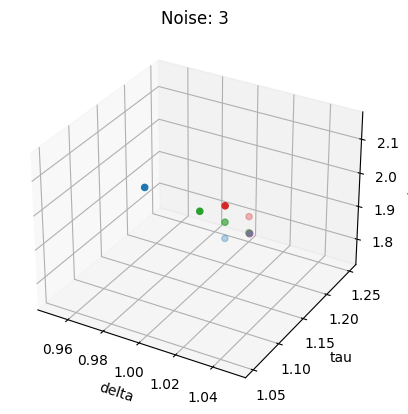

In [61]:
noise = 3
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

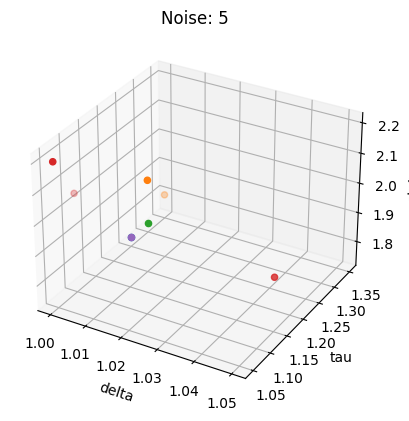

In [62]:
noise = 5
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

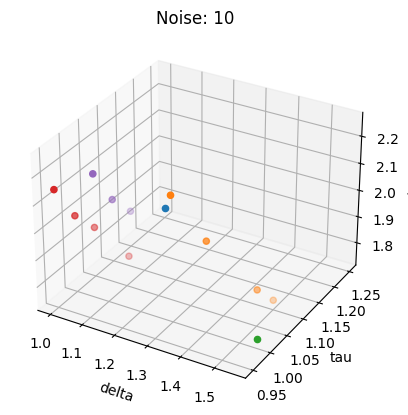

In [63]:
noise = 10
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()